This notebook is updated by Godhuli De.

In [5]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from imblearn.over_sampling import ADASYN

#For ignoring warning
import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv('survey lung cancer.csv')

#Removing Duplicates
df=df.drop_duplicates()
df.isnull().sum()
df.shape

# Normalize categorical values to 0 & 1 using LabelEncoder
label_columns = ['GENDER', 'LUNG_CANCER', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
                 'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ',
                 'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
                 'SWALLOWING DIFFICULTY', 'CHEST PAIN']

le = preprocessing.LabelEncoder()
for column in label_columns:
    df[column] = le.fit_transform(df[column])

df

df_new=df.drop(columns=['GENDER','AGE', 'SMOKING', 'SHORTNESS OF BREATH'])
df_new

#Splitting independent and dependent variables
X = df_new.drop('LUNG_CANCER', axis = 1)
y = df_new['LUNG_CANCER']


adasyn = ADASYN(random_state=42)
X, y = adasyn.fit_resample(X, y)

# Creating an ensemble model for cancer prediction using SVM, RF, GrBoosting,XGBClassifier

Training SVM...
Best parameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation accuracy for SVM: 0.9091
Training Random Forest...
Best parameters for Random Forest: {'max_depth': 30, 'n_estimators': 300}
Best cross-validation accuracy for Random Forest: 0.9000
Training Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'n_estimators': 100}
Best cross-validation accuracy for Gradient Boosting: 0.8864
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation accuracy for XGBoost: 0.9000
Ensemble Model Accuracy: 0.8571
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        12
           1       0.85      1.00      0.92        44

    accuracy                           0.86        56
   macro avg       0.92      0.67      0.71        56
weighted avg       0.88      0.86      0.83        56



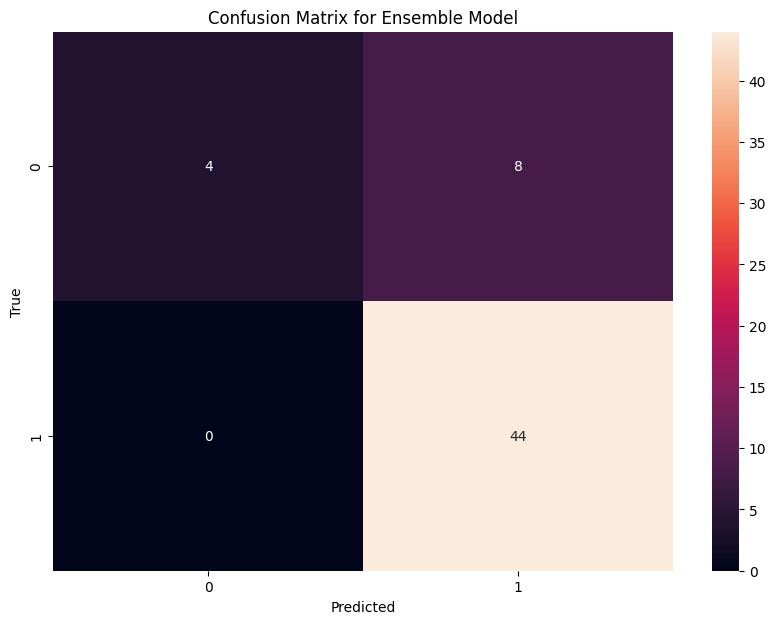

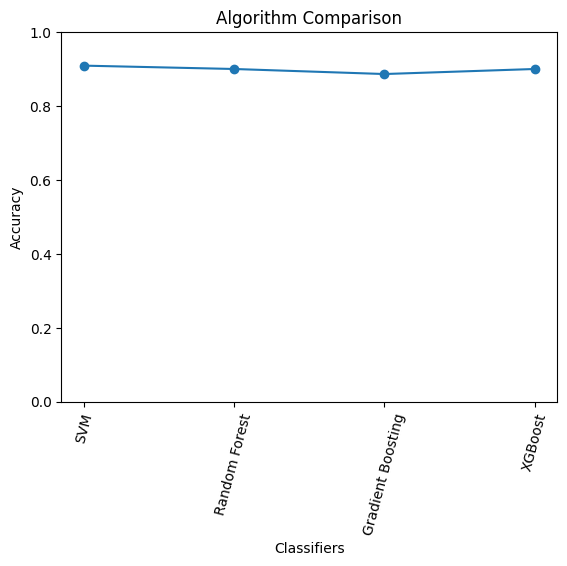

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier


# Load and preprocess data
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction (optional)
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


# Define models
models = {
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Hyperparameter grids for tuning
param_grids = {
    'SVM': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
}

best_models = {}
names = []
results = []

for model_name in models:
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    names.append(model_name)
    results.append(grid_search.best_score_)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}")


#

# Ensemble model using the best models from GridSearchCV
ensemble_model = VotingClassifier(estimators=[
    ('SVM', best_models['SVM']),
    ('Random Forest', best_models['Random Forest']),
    ('Gradient Boosting', best_models['Gradient Boosting']),
    ('XGBoost', best_models['XGBoost'])
], voting='soft')

ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model
ensemble_pred = ensemble_model.predict(X_test)
ensemble_acc = accuracy_score(y_test, ensemble_pred)
print(f'Ensemble Model Accuracy: {ensemble_acc:.4f}')
print(classification_report(y_test, ensemble_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()


plt.title('Algorithm Comparison')
plt.xticks(rotation=75)
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.plot(names, results, marker='o')
plt.ylim([0, 1])
plt.show()